In [1]:
# 필요한 패키지 불러오기
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    accuracy_score,
    classification_report,
)
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
import seaborn as sns

In [3]:
# 파일 불러오기
member_df = pd.read_csv("data/member.csv", index_col=0)

In [29]:
member_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111851 entries, 0 to 111850
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   userid                       111851 non-null  object 
 1   gender                       111851 non-null  object 
 2   membertype_codename          111851 non-null  object 
 3   grade_codename               111851 non-null  object 
 4   memberstatus                 111851 non-null  int64  
 5   memberstatus_codename        111851 non-null  object 
 6   memberstatus_change          111851 non-null  object 
 7   status_null_count            111851 non-null  int64  
 8   statusgroup_10_count         111851 non-null  int64  
 9   statusgroup_20_count         111851 non-null  int64  
 10  statusgroup_30_count         111851 non-null  int64  
 11  statusgroup_40_count         111851 non-null  int64  
 12  statusgroup_50_count         111851 non-null  int64  
 13  stat

In [30]:
member_df.describe()

,memberstatus,status_null_count,statusgroup_10_count,statusgroup_20_count,statusgroup_30_count,statusgroup_40_count,statusgroup_50_count,statusgroup_90_count,point_gain_activeday_count,point_gain_count,...,test_activeday_count,test_count,test_average_score,test_item_count,test_correct_count,wrong_count,wrong_item_count,wrong_correct_count,yyyy,mm
count,111851.000000,111851.000000,111851.0,111851.000000,111851.000000,111851.000000,111851.000000,111851.000000,107896.000000,107896.000000,...,28999.000000,28999.000000,28999.000000,28379.000000,28379.000000,7443.000000,7443.000000,7443.000000,111851.0,111851.000000
mean,44.560764,1.673807,0.0,3.221035,1.906840,0.175323,23.578976,0.114357,1.861802,11.464410,...,3.803304,9.091417,81.535343,46.744670,37.227950,4.165122,6.555421,6.335080,2022.0,9.527657
std,4.443222,4.284554,0.0,5.912405,5.946677,1.969526,9.970680,1.479662,3.206405,25.778183,...,2.993798,10.728937,17.329415,59.159502,46.391778,4.821318,8.735059,8.689455,0.0,1.713339
min,44.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2022.0,1.000000
25%,44.000000,0.000000,0.0,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,...,2.000000,3.000000,74.000000,13.000000,10.000000,1.000000,2.000000,2.000000,2022.0,8.000000
50%,44.000000,0.000000,0.0,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,...,3.000000,6.000000,85.450000,31.000000,25.000000,3.000000,4.000000,4.000000,2022.0,10.000000
75%,44.000000,1.000000,0.0,5.000000,0.000000,0.000000,31.000000,0.000000,3.000000,9.000000,...,5.000000,12.000000,94.000000,58.000000,47.000000,5.000000,8.000000,8.000000,2022.0,11.000000
max,88.000000,30.000000,0.0,30.000000,30.000000,31.000000,31.000000,31.000000,29.000000,877.000000,...,27.000000,697.000000,100.000000,3449.000000,2471.000000,92.000000,195.000000,195.000000,2022.0,12.000000


In [31]:
member_df.describe(include="O")

,userid,gender,membertype_codename,grade_codename,memberstatus_codename,memberstatus_change
count,111851,111851,111851,111851,111851,111851
unique,65572,3,1,17,3,234
top,dca3ce04-ecb5-4e89-8058-0b4ee6316c30,M,초등,초6,학습생(만료),44
freq,6,62615,111851,17582,109892,54396


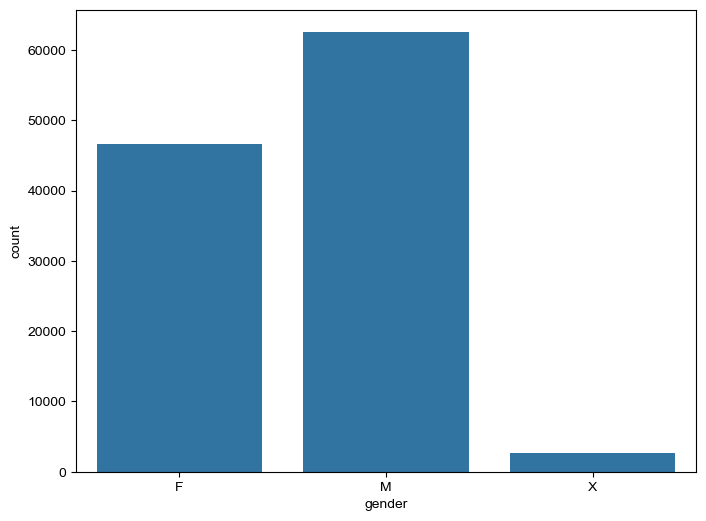

In [32]:
# 여성남성 분포
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.rcParams["font.family"] = "Malgun Gothic"
sns.countplot(x="gender", data=member_df)
plt.show()

In [10]:
member_df["gender"].value_counts()

gender
M    62615
F    46585
X     2651
Name: count, dtype: int64

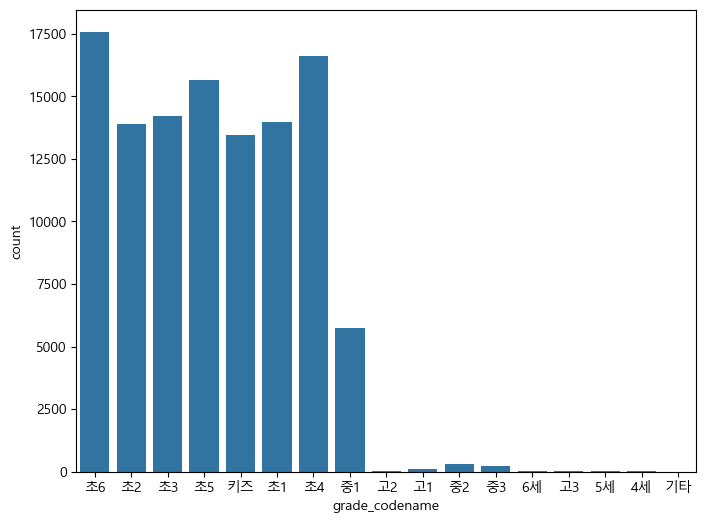

In [33]:
# 회원 분포 확인
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.rcParams["font.family"] = "Malgun Gothic"
sns.countplot(x="grade_codename", data=member_df)
plt.show()

In [11]:
elementary_count = member_df['grade_codename'].str.contains('초').sum()

# 전체 행 수
total_count = len(member_df)

# 비율 계산
ratio = elementary_count / total_count

print(f"'초'가 포함된 데이터의 비율: {ratio:.2%}")

'초'가 포함된 데이터의 비율: 82.15%


In [34]:
# 결측치 확인하기
member_df.isnull().sum()

userid                              0
gender                              0
membertype_codename                 0
grade_codename                      0
memberstatus                        0
memberstatus_codename               0
memberstatus_change                 0
status_null_count                   0
statusgroup_10_count                0
statusgroup_20_count                0
statusgroup_30_count                0
statusgroup_40_count                0
statusgroup_50_count                0
statusgroup_90_count                0
point_gain_activeday_count       3955
point_gain_count                 3955
point_gain                       3955
point_loss_activeday_count       3955
point_loss_count                 3955
point_loss                       3955
tablet_activeday_count          69893
tablet_moved_menu_count         69893
tablet_leave_count              69893
tablet_resume_count             69893
tablet_login_count              69893
tablet_logout_count             69893
study_active

In [13]:
# 결측치가 많은 열들 제거(결측값 비율 90% 이상 기준)
missing_values_percentage = (
    member_df.isnull().sum().sort_values(ascending=False) / len(member_df)
) * 100
drop_cols = missing_values_percentage[missing_values_percentage > 90].index

member_df_cleaned = member_df.drop(columns=drop_cols)

In [14]:
member_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111851 entries, 0 to 111850
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   userid                       111851 non-null  object 
 1   gender                       111851 non-null  object 
 2   membertype_codename          111851 non-null  object 
 3   grade_codename               111851 non-null  object 
 4   memberstatus                 111851 non-null  int64  
 5   memberstatus_codename        111851 non-null  object 
 6   memberstatus_change          111851 non-null  object 
 7   status_null_count            111851 non-null  int64  
 8   statusgroup_10_count         111851 non-null  int64  
 9   statusgroup_20_count         111851 non-null  int64  
 10  statusgroup_30_count         111851 non-null  int64  
 11  statusgroup_40_count         111851 non-null  int64  
 12  statusgroup_50_count         111851 non-null  int64  
 13  stat

In [37]:
member_df_cleaned.isnull().sum()

userid                             0
gender                             0
membertype_codename                0
grade_codename                     0
memberstatus                       0
memberstatus_codename              0
memberstatus_change                0
status_null_count                  0
statusgroup_10_count               0
statusgroup_20_count               0
statusgroup_30_count               0
statusgroup_40_count               0
statusgroup_50_count               0
statusgroup_90_count               0
point_gain_activeday_count      3955
point_gain_count                3955
point_gain                      3955
point_loss_activeday_count      3955
point_loss_count                3955
point_loss                      3955
tablet_activeday_count         69893
tablet_moved_menu_count        69893
tablet_leave_count             69893
tablet_resume_count            69893
tablet_login_count             69893
tablet_logout_count            69893
study_activeday_count          77821
s

C:\Users\Owner\AppData\Local\Temp\ipykernel_24608\3708820914.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["event_observed"] = filtered_df["memberstatus_codename"].apply(
C:\Users\Owner\AppData\Local\Temp\ipykernel_24608\3708820914.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["event_observed"] = filtered_df["memberstatus_codename"].apply(


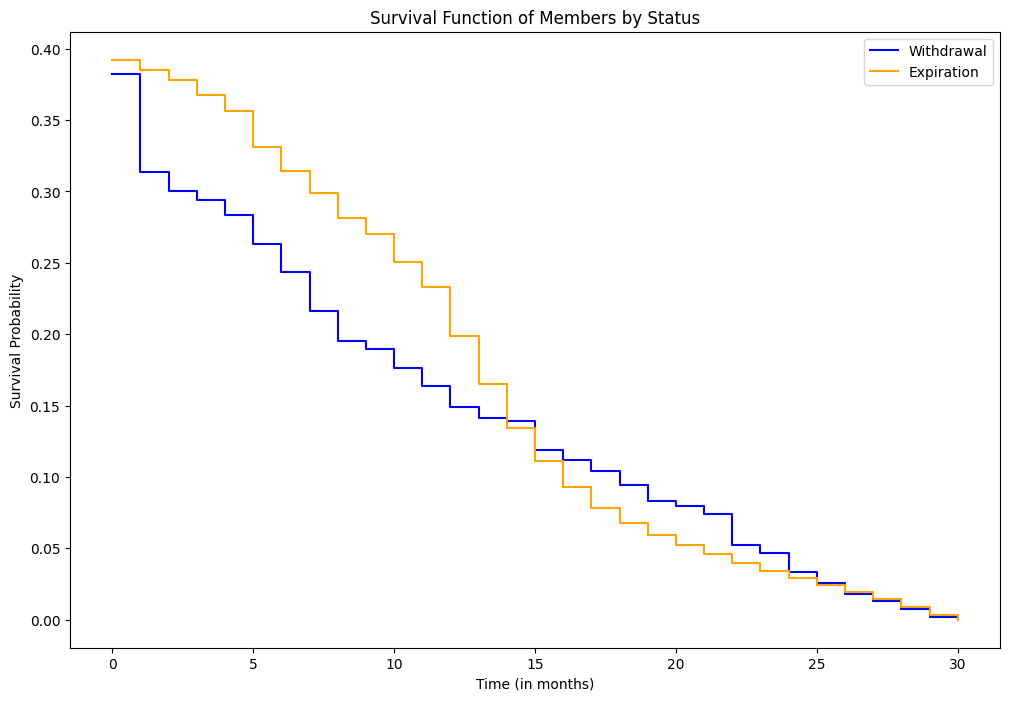

In [16]:
def estimate_join_time(row):
    # 각 상태별 일수를 합산하여 가입 일수를 추정
    total_days = (
        row["statusgroup_10_count"]
        + row["statusgroup_20_count"]
        + row["statusgroup_30_count"]
    )

    # 가입 일수은 일수 합계로 추정
    return total_days


# 가입 일수 열 추가
member_df_cleaned["join_time"] = member_df_cleaned.apply(estimate_join_time, axis=1)


# 상태별로 데이터를 나누기
def get_survival_data(df, status):
    filtered_df = df[df["memberstatus_codename"].str.contains(status)]
    filtered_df["event_observed"] = filtered_df["memberstatus_codename"].apply(
        lambda x: True if "탈퇴" in x or "만료" in x else False
    )
    survival_data = np.array(
        list(zip(filtered_df["event_observed"], filtered_df["join_time"])),
        dtype=[("event_observed", "?"), ("join_time", "<f8")],
    )
    return survival_data


# 탈퇴 및 만료 상태 분리
survival_data_withdrawal = get_survival_data(member_df_cleaned, "탈퇴")
survival_data_expiration = get_survival_data(member_df_cleaned, "만료")

# Kaplan-Meier 분석
time_withdrawal, survival_prob_withdrawal = kaplan_meier_estimator(
    survival_data_withdrawal["event_observed"], survival_data_withdrawal["join_time"]
)
time_expiration, survival_prob_expiration = kaplan_meier_estimator(
    survival_data_expiration["event_observed"], survival_data_expiration["join_time"]
)

# 결과 시각화
plt.figure(figsize=(12, 8))
plt.step(
    time_withdrawal,
    survival_prob_withdrawal,
    where="post",
    label="Withdrawal",
    color="blue",
)
plt.step(
    time_expiration,
    survival_prob_expiration,
    where="post",
    label="Expiration",
    color="orange",
)
plt.title("Survival Function of Members by Status")
plt.xlabel("Time (in months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

- 30개월이 만료 시점
- 1년이 지나면 탈퇴비율이 만료비율보다 높아지고 2년이 지나면 거의 동일한 비율로 수렴함

In [18]:
# 사용할 특성 컬럼 리스트
feature_columns = [
    "point_gain_activeday_count",
    "point_gain_count",
    "point_gain",
    "point_loss_activeday_count",
    "point_loss_count",
    "point_loss",
    "tablet_activeday_count",
    "tablet_moved_menu_count",
    "tablet_leave_count",
    "tablet_resume_count",
    "tablet_login_count",
    "tablet_logout_count",
    "study_activeday_count",
    "study_count",
    "study_notcompleted_count",
    "study_completed_count",
    "study_restart_count",
    "total_system_learning_time",
    "total_caliper_learning_time",
    "media_activeday_count",
    "media_count",
    "video_action_count",
    "video_start_count",
    "video_restart_count",
    "video_pause_count",
    "video_jump_count",
    "video_resume_count",
    "video_speed_count",
    "video_volume_count",
    "video_end_count",
    "test_activeday_count",
    "test_count",
    "test_average_score",
    "test_item_count",
    "test_correct_count",
]

# 상태 필터링 및 타겟 변수 생성
filtered_data = member_df_cleaned[
    member_df_cleaned["memberstatus_codename"].isin(["학습생(만료)", "학습생(탈퇴)"])
]
filtered_data["target"] = filtered_data["memberstatus_codename"].apply(
    lambda x: 1 if x == "학습생(탈퇴)" else 0
)

# 특성 데이터와 타겟 변수 준비
X = filtered_data[feature_columns]
X = X.dropna()  # 결측치가 있는 행 제거
filtered_data = filtered_data.loc[X.index]  # X와 맞는 filtered_data만 남기기
y = Surv.from_arrays(event=filtered_data["target"], time=filtered_data["join_time"])

# 범주형 변수를 원-핫 인코딩
X_encoded = pd.get_dummies(X)

# 데이터 프레임을 넘파이 배열로 변환 (밀집 행렬)
X_dense = X_encoded.values

# 피처 중요도 스코어 계산 함수
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    model = CoxPHSurvivalAnalysis()

    for j in range(n_features):
        Xj = X[:, j : j + 1]  # j번째 컬럼을 2D 배열로 추출
        model.fit(Xj, y)
        scores[j] = model.score(Xj, y)

    return scores


# 모델 학습 및 피처 중요도 스코어 계산
scores = fit_and_score_features(X_dense, y)

# 피처 중요도 스코어 출력
feature_names = X_encoded.columns
scores_series = pd.Series(scores, index=feature_names).sort_values(ascending=False)
print(scores_series)

C:\Users\Owner\AppData\Local\Temp\ipykernel_24608\1512279265.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["target"] = filtered_data["memberstatus_codename"].apply(
c:\Users\Owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sksurv\linear_model\coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])


point_loss                     0.853039
point_loss_activeday_count     0.821886
study_activeday_count          0.800902
tablet_activeday_count         0.789357
point_loss_count               0.788748
media_activeday_count          0.785381
test_activeday_count           0.767817
point_gain_activeday_count     0.721646
tablet_logout_count            0.651109
tablet_leave_count             0.636167
test_count                     0.623876
tablet_resume_count            0.611667
video_volume_count             0.597069
total_system_learning_time     0.595679
video_end_count                0.586641
video_jump_count               0.586592
video_restart_count            0.580683
study_restart_count            0.580034
test_item_count                0.565845
study_count                    0.563609
video_start_count              0.559403
test_correct_count             0.558401
point_gain_count               0.554387
video_action_count             0.553109
test_average_score             0.550747


In [40]:
# 결과를 DataFrame으로 변환하고 출력
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance Score": scores}
).sort_values(by="Importance Score", ascending=False)

importance_df

,Feature,Importance Score
5,point_loss,0.853039
3,point_loss_activeday_count,0.821886
12,study_activeday_count,0.800902
6,tablet_activeday_count,0.789357
4,point_loss_count,0.788748
19,media_activeday_count,0.785381
30,test_activeday_count,0.767817
0,point_gain_activeday_count,0.721646
11,tablet_logout_count,0.651109
8,tablet_leave_count,0.636167


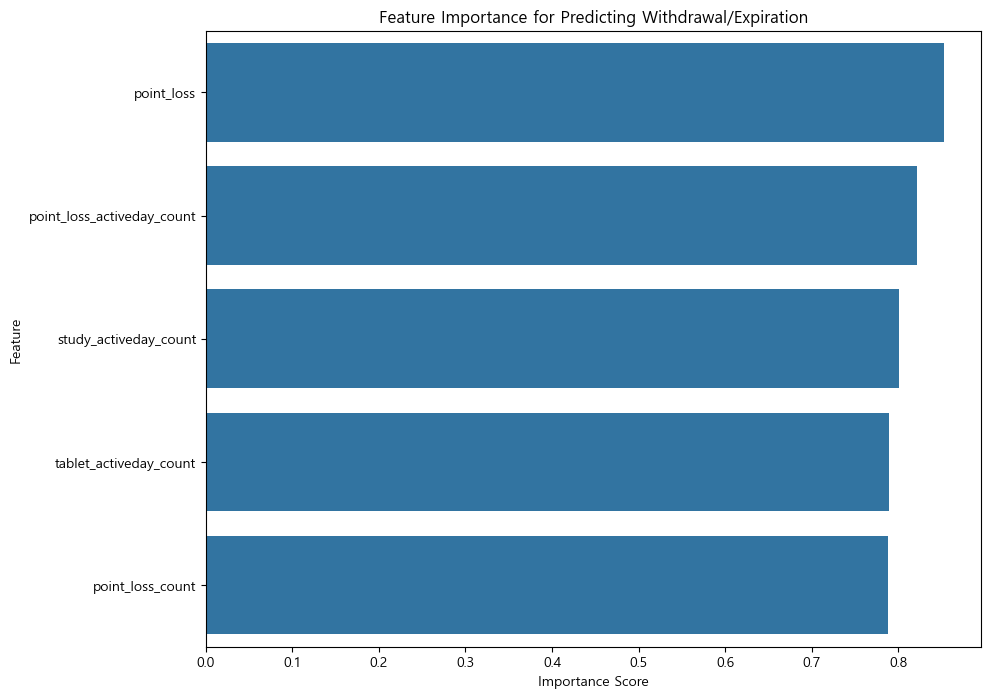

In [41]:
# 변수 중요도 상위 5개 컬럼
top5 = scores_series.head()

# 변수 중요도 바 그래프
plt.figure(figsize=(10, 8))
sns.barplot(x=top5.values, y=top5.index)
plt.title("Feature Importance for Predicting Withdrawal/Expiration")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

- 포인트 손실이 크게 영향을 미침.

In [42]:
point_loss_and_withdrawal = filtered_data[["point_loss", "join_time", "target"]]

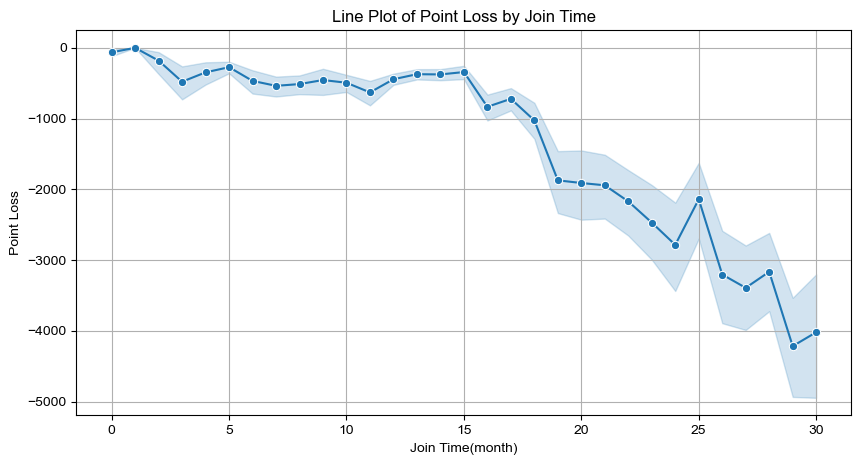

In [43]:
plt.rcParams["font.family"] = "Arial"
plt.figure(figsize=(10, 5))
sns.lineplot(x="join_time", y="point_loss", data=point_loss_and_withdrawal, marker="o")
plt.title("Line Plot of Point Loss by Join Time")
plt.xlabel("Join Time(month)")
plt.ylabel("Point Loss")
plt.grid(True)
plt.show()

In [20]:
important_features = ["point_loss", "point_loss_activeday_count", "point_loss_count"]

# 특성과 타겟 데이터 준비
X = filtered_data[important_features].dropna()
y = filtered_data["target"]

In [21]:
y.value_counts()

target
0    26809
1       11
Name: count, dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12345
)

In [46]:
# 모델 학습
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# 예측 및 평가
y_pred = log_reg.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Rooted Mean Squared Error: {mse}")

Rooted Mean Squared Error: 0.01930948154544974


In [47]:
# 혼동표 생성
cm = confusion_matrix(y_test, y_pred)

# 이진 분류 혼동표
confusion_df = pd.DataFrame(
    cm,
    columns=["ex_pred", "wd_pred"],  # 예측된 만료, 탈퇴
    index=["ex_truth", "wd_truth"],  # 실제 만료, 탈퇴
)

confusion_df

,ex_pred,wd_pred
ex_truth,8043,0
wd_truth,3,0


In [48]:
# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9996271439224459


In [49]:
# 예측 및 평가
y_pred = log_reg.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8043
           1       0.00      0.00      0.00         3

    accuracy                           1.00      8046
   macro avg       0.50      0.50      0.50      8046
weighted avg       1.00      1.00      1.00      8046



c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
